In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import re

In [15]:
import datetime

In [16]:
import os

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from plotting import *

In [19]:
LOSS_INDEX = 3

## Acquisition

#### Directory that contains all the experiment subdirectories

In [20]:
base_dir = '../knl-tuning-runs/log'

In [21]:
base_dir = '../knl-archive-runs/log_archive'

In [22]:
n_workers = 8

In [23]:
experiment_name = 'imagenet_tuning_W' + str(n_workers)

In [24]:
all_matching_experiments = []

In [25]:
for directory in os.walk(base_dir):
    if directory[0].startswith(base_dir + '/'+ experiment_name):
        all_matching_experiments.append(directory[0])
print 'Found the following matching experiments : '
print '\n'.join(all_matching_experiments)

Found the following matching experiments : 
../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-22-22:13_master_branch
../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight


### Either let the script pick the most recent matching experiment, 

In [26]:
if len(all_matching_experiments)==0:
    print 'No experiments matching prefix ' + experiment_name
    experiment_directory = None
else:
    experiment_directory = [sorted(all_matching_experiments)[-1]]
    if len(all_matching_experiments)>1:
        print 'Selecting ' + experiment_directory[0] + ' out of ' + str(len(all_matching_experiments)) + ' matching experiments.'
    else:
        print 'Selecting ' + experiment_directory[0]

Selecting ../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight out of 2 matching experiments.


### Or manually sellect one,

In [81]:
experiment_directory=['../knl-imit-runs/log/imagenet_tuning_W8_2016-10-22-21:50']

### Or manually sellect many

In [103]:
experiment_directory=['../cifar10/log/tuning_W8_2016-10-16-00:41',
                      '../cifar10/log/tuning_W8_2016-10-16-13:11'
                      ]

### Or manually sellect all

In [28]:
experiment_directory = all_matching_experiments

### Load logs from selected experiment

In [27]:
parameter_values = {}

all_configs = []

if not type(experiment_directory) == list:
    experiment_directory = [experiment_directory]

for this_exp_dir in experiment_directory:
    print
    print 'From directory ' + this_exp_dir
    for fname in os.listdir(this_exp_dir):
        assert(fname[-4:]=='.log')
        parameter_strings = fname[:-4].split('_')
        print 'Loading ' + fname
        for pstring in parameter_strings:
            p,v = pstring.split('=')
            parameter_values[p] = float(v)
            if p=='W':
                assert(int(v)==n_workers)
        print this_exp_dir + '/' + fname
        all_lines = load_results(this_exp_dir + '/' + fname)
        all_configs.append([parameter_values.copy(), all_lines])


From directory ../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight
Loading W=8_G=1_LR=0.0003_mu=0.0.log
../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight/W=8_G=1_LR=0.0003_mu=0.0.log
Loading W=8_G=1_LR=0.0003_mu=0.3.log
../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight/W=8_G=1_LR=0.0003_mu=0.3.log
Loading W=8_G=1_LR=0.0003_mu=0.6.log
../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight/W=8_G=1_LR=0.0003_mu=0.6.log
Loading W=8_G=1_LR=0.0003_mu=0.9.log
../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight/W=8_G=1_LR=0.0003_mu=0.9.log
Loading W=8_G=1_LR=0.001_mu=0.0.log
../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight/W=8_G=1_LR=0.001_mu=0.0.log
Loading W=8_G=1_LR=0.001_mu=0.3.log
../knl-archive-runs/log_archive/imagenet_tuning_W8_2016-10-23-02_async_branch_overnight/W=8_

## Plot all configs

In [30]:
W = 60

In [31]:
import matplotlib.cm as cm

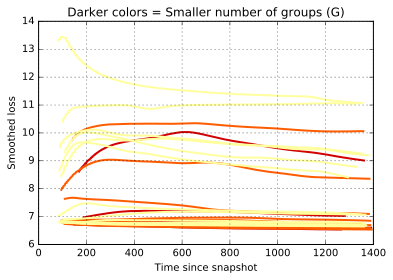

In [32]:
for config in all_configs:
    G = int(config[0]['G'])
    losses_per_batch = int(np.round(float(n_workers)/G))
    
    if len(config[1]) < 2*W*losses_per_batch:
        print config[0], ' run too short. Was is terminated?'
        continue

    all_seconds, all_losses = get_times_losses(config[1])

    plt.plot(all_seconds, moving_average(all_losses,window_size=W*losses_per_batch),
             '-',linewidth=2, label=str(config[0]), 
             color=cm.hot((config[0]['G']+1.0)/float(n_workers+2)) )
plt.grid()
#plt.axis([None, None, 0.7, 1.0]);
plt.title('Darker colors = Smaller number of groups (G)')
plt.ylabel('Smoothed loss')
plt.xlabel('Time since snapshot')

### Plots best configs per group 

In [33]:
best_configs = get_best_config_per_group(n_workers, all_configs,W=W)

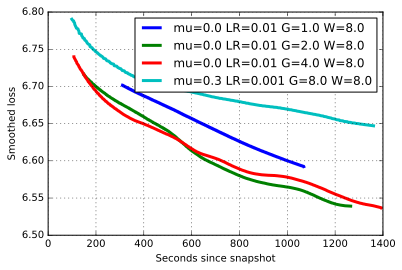

In [34]:
for G in sorted(best_configs.keys()):
    config = best_configs[G]
    all_seconds, all_losses = get_times_losses(config[1])
    losses_per_batch = int(np.round(float(n_workers)/G))
    plt.plot(all_seconds, moving_average(all_losses,window_size=W*losses_per_batch),
             '-',linewidth=3,
             label=' '.join([p+'='+str(config[0][p]) for p in config[0]])
    )
plt.xlabel('Seconds since snapshot')
plt.ylabel('Smoothed loss')
plt.legend()
plt.grid()
#plt.axis([None, None, 0.7, 1.0]);

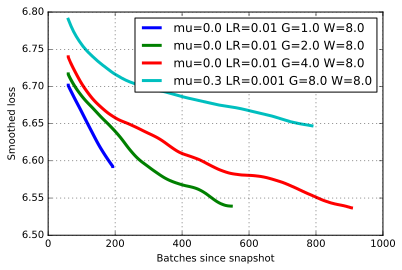

In [35]:
for G in sorted(best_configs.keys()):
    config = best_configs[G]
    all_seconds, all_losses = get_times_losses(config[1])
    losses_per_batch = int(np.round(float(n_workers)/G))
    all_batches = np.arange(len(all_losses))/losses_per_batch
    plt.plot(all_batches, moving_average(all_losses,window_size=W*losses_per_batch),
             '-',linewidth=3,
             label=' '.join([p+'='+str(config[0][p]) for p in config[0]])
    )
plt.xlabel('Batches since snapshot')
plt.ylabel('Smoothed loss')
plt.legend()
plt.grid()
#plt.axis([None, None, 0.7, 1.0]);

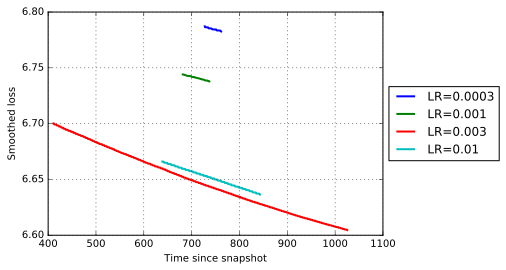

In [36]:
plot_matching_configs(all_configs,{'W':8, 'G':1, 'mu':0.6}, W=80)

In [37]:
n=n_workers

In [38]:
def get_num_batches_1(configs):
    batches = []
    for config in configs:
        G = int(config[0]['G'])
        iter0=config[1][0][2]
        max_iter = np.max([line[2] for line in config[1]])
        batches.append(G*(max_iter-iter0))
    return batches


In [39]:
def get_num_batches_2(configs):
    batches = []
    for config in configs:
        G = int(config[0]['G'])
        n_workers = int(config[0]['W'])
        batches.append(len(config[1])/(n_workers/G))
    return batches


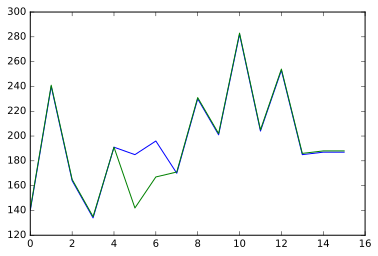

In [40]:
plt.plot(get_num_batches_1(get_matching_configs(all_configs,{'G':1})))

plt.plot(get_num_batches_2(get_matching_configs(all_configs,{'G':1})))

In [41]:
matching_configs = get_matching_configs(all_configs,{'G':1})

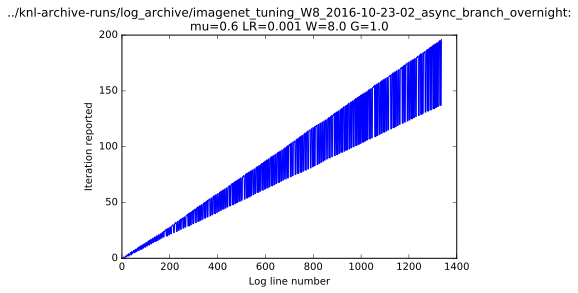

In [42]:
plt.plot([line[2]-15000 for line in matching_configs[6][1]])
plt.title(experiment_directory[0] + ':\n' + string_from_dict(matching_configs[6][0]))
plt.xlabel('Log line number')
plt.ylabel('Iteration reported')

####  Batch number statistics

In [43]:
all_batch_nums = get_num_batches_2(get_matching_configs(all_configs,{'G':1}))

In [44]:
np.min(all_batch_nums)

135

In [45]:
np.mean(all_batch_nums)

193.125

In [46]:
np.max(all_batch_nums)

283

In [47]:
np.sqrt(np.var(all_batch_nums))

40.704537523475196

In [48]:
def get_times_and_batches(configs):
    batches = []
    seconds_per_batch = []
    for config in configs:
        G = int(config[0]['G'])
        n_workers = int(config[0]['W'])
        batches_finished = len(config[1])/(n_workers/G)
        batches.append(batches_finished)
        all_lines = config[1]
        all_seconds, all_losses = get_times_losses(all_lines)

        seconds_per_batch.append(batches_finished)
        
    return batches, seconds_per_batch


In [49]:
b, s = get_times_and_batches(matching_configs)

### Per step timings

In [50]:
config = matching_configs[6]

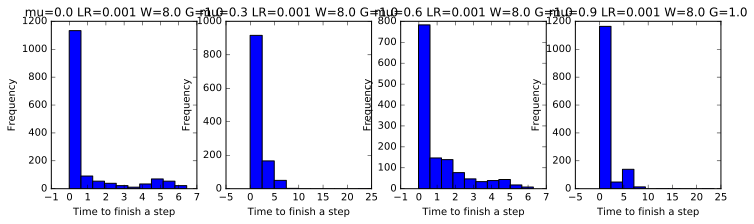

In [54]:
plot_config_timings_histogram(matching_configs[4:8],bins=0.5+np.linspace(0,9,10))

In [ ]:
#     f, axarr = plt.subplots(1,n_plots,figsize=(3*n_plots,3))
#     print axarr
#     for i in range(n_plots):


In [86]:
# def plot_worker_timings_histogram(config):
    
#     print 'Timings from ' + string_from_dict(config[0])
    
#     W=int(config[0]['W'])
    
#     grid_width = int(np.ceil(np.sqrt(W)))
    
#     f, axarr = plt.subplots(grid_width,grid_width,figsize=(3*grid_width,3*grid_width))

#     for wi in range(W):
#         lines_worker_0 = [line for line in config[1] if line[1]==wi]
#         all_seconds, all_losses = get_times_losses(lines_worker_0)

#         all_timings = np.array(all_seconds[1:]) - np.array(all_seconds[:-1])

#         i=wi/grid_width
#         j=wi%grid_width
#         axarr[i,j].hist(all_timings)
#         axarr[i,j].set_xlabel('Time to finish a step')
#         axarr[i,j].set_ylabel('Frequency')
#         axarr[i,j].set_title('Worker '+ str(wi))

Timings from mu=0.6 LR=0.001 W=8.0 G=1.0


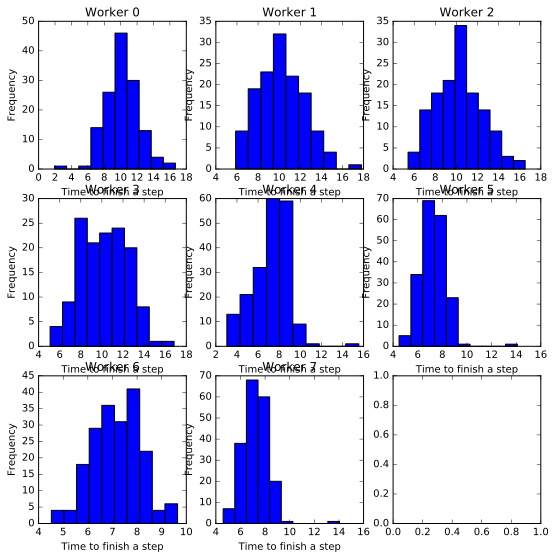

In [87]:
plot_worker_timings_histogram(config)

In [71]:
all_seconds, all_losses = get_times_losses(config[1])

### Per worker timings 

In [41]:
all_configs[0][1]

[[datetime.datetime(1900, 1, 1, 2, 19, 55, 853111), 3, 15000, 6.50122],
 [datetime.datetime(1900, 1, 1, 2, 19, 55, 863179), 0, 15000, 6.68356],
 [datetime.datetime(1900, 1, 1, 2, 19, 55, 925531), 4, 15000, 6.59304],
 [datetime.datetime(1900, 1, 1, 2, 19, 55, 935359), 6, 15000, 6.49842],
 [datetime.datetime(1900, 1, 1, 2, 19, 55, 983122), 7, 15000, 7.08873],
 [datetime.datetime(1900, 1, 1, 2, 19, 55, 978377), 1, 15000, 6.35902],
 [datetime.datetime(1900, 1, 1, 2, 19, 56, 230280), 5, 15000, 7.0781],
 [datetime.datetime(1900, 1, 1, 2, 19, 56, 854809), 2, 15000, 6.42321],
 [datetime.datetime(1900, 1, 1, 2, 19, 58, 913529), 0, 15001, 6.78708],
 [datetime.datetime(1900, 1, 1, 2, 19, 59, 193441), 2, 15001, 6.82968],
 [datetime.datetime(1900, 1, 1, 2, 19, 59, 395977), 1, 15001, 6.85446],
 [datetime.datetime(1900, 1, 1, 2, 19, 59, 447870), 4, 15001, 7.17151],
 [datetime.datetime(1900, 1, 1, 2, 19, 59, 473446), 6, 15001, 6.55433],
 [datetime.datetime(1900, 1, 1, 2, 19, 59, 544239), 7, 15001, 7.3

### HE SE

In [41]:
def get_he_se_numbers_from_log_lines(all_lines,n,g,group_batch=True):

    all_seconds, all_losses = get_times_losses(all_lines)

    iters =[line[2] for line in all_lines]
    
    if group_batch:
        # Each group is responsible of a mini-batch
        #total_batches=g*(np.max(iters)-iters[0])
    else:
        # Each worker is responsible for a mini-batch
        total_batches=n*(np.max(iters)-iters[0])

    total_time = all_seconds[-1]

    seconds_per_batch = total_time/total_batches
    
    return seconds_per_batch, total_batches, total_time



## Set numbers of groups to focus on here

In [42]:
all_g = [1,2,4,8]

In [43]:
for G in all_g:
    print get_he_se_numbers_from_log_lines(best_configs[G][1], n_workers, G)

(7.441984470833333, 240, 1786.076273)
(2.1680939055727553, 646, 1400.588663)
(1.2040026623376625, 1232, 1483.33128)
(1.418444371124031, 1032, 1463.834591)


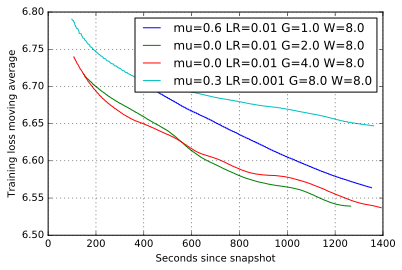

In [44]:
all_seconds_per_batch=[]
all_total_batches=[]
all_total_time=[]
for G in all_g:
    losses_per_batch = int(np.round(float(n_workers)/G))
    Weff = W*losses_per_batch
    all_lines = best_configs[G][1]
    seconds, losses = get_times_losses(all_lines)
    plt.plot(seconds,moving_average(losses,Weff),
             label=' '.join([p+'='+str(best_configs[G][0][p]) for p in best_configs[G][0]])
    )

plt.xlabel('Seconds since snapshot')
plt.ylabel('Training loss moving average')
plt.legend()
plt.grid()
#plt.axis([None, None, 0.7, 0.9])

### Calculate the target loss: lowest loss achieved by all configurations

In [45]:
all_losses=[]
all_seconds=[]
max_min_loss = -np.inf
for G in all_g:
    losses_per_batch = int(np.round(float(n_workers)/G))
    all_lines = best_configs[G][1]
    seconds, losses = get_times_losses(all_lines)
    losses = moving_average(losses, W*losses_per_batch)
    all_losses.append(losses)
    all_seconds.append(seconds)
    if np.nanmin(losses)>max_min_loss:
        max_min_loss = np.nanmin(losses)
print max_min_loss

6.64708078889


### Estimate the time (in seconds) it took each configuration to reach this target loss

In [46]:
assert(not np.isinf(max_min_loss))
all_crossings =[]
for gi in range(len(all_g)):
    G=all_g[gi]
    losses_per_batch = int(np.round(float(n_workers)/G))
    Weff = W*losses_per_batch
    losses = all_losses[gi]
    seconds = all_seconds[gi]
    crossing_index = np.nonzero(losses[Weff:-Weff]<=max_min_loss)[0][0]+Weff
    crossing_time = seconds[crossing_index]
    #crossing_time = seconds[np.nonzero(losses[W:-W]<=max_min_loss)[0][0]+W]
    all_crossings.append(crossing_time)

In [47]:
all_crossings

[725.295012, 466.150762, 420.227314, 1360.702798]

### Calculate how many iterations (batches) were required to reach target loss 

In [48]:
all_seconds_per_batch=[]
all_total_batches=[]
all_total_time=[]
all_batches_to_target=[]
for gi in range(len(all_g)):
    g=all_g[gi]
    spb, tb, tt = get_he_se_numbers_from_log_lines(best_configs[g][1], n_workers, g)
    #get_he_se_numbers(experiment_name,4,g)
    all_seconds_per_batch.append(spb)
    all_total_batches.append(tb)
    all_total_time.append(tt)
    all_batches_to_target.append(np.ceil(all_crossings[gi]/spb))
    

In [49]:
all_batches_to_target

[98.0, 216.0, 350.0, 960.0]

### Hardware efficiency

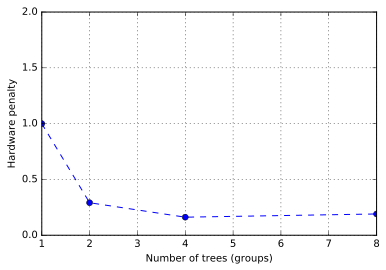

In [50]:
plt.plot(all_g,np.array(all_seconds_per_batch)/all_seconds_per_batch[0],'o--')
plt.grid()
plt.ylabel('Hardware penalty')
plt.axis([None, None, 0, 2]);
plt.xlabel('Number of trees (groups)')

In [51]:
all_seconds_per_batch

[7.441984470833333, 2.1680939055727553, 1.2040026623376625, 1.418444371124031]

### Statistical efficiency 

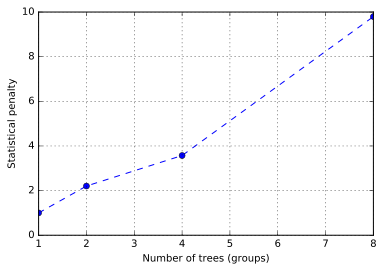

In [52]:
plt.plot(all_g,all_batches_to_target/all_batches_to_target[0], 'o--')
plt.grid()
plt.ylabel('Statistical penalty')
plt.axis([None, None, 0, 10])
plt.xlabel('Number of trees (groups)')

### Efficiency Triplet 

In [53]:
def plot_he(ax):
    ax.plot(all_g,np.array(all_seconds_per_batch)/all_seconds_per_batch[0],'o--')
    ax.grid()
    ax.set_ylabel('Hardware penalty')
    ax.axis([None, None, 0, 2]);
    ax.set_xlabel('# groups')

In [54]:
def plot_se(ax):
    ax.plot(all_g,all_batches_to_target/all_batches_to_target[0], 'o--')
    ax.grid()
    ax.set_ylabel('Statistical penalty')
    ax.axis([None, None, 0, 10])
    ax.set_xlabel('# groups')


In [55]:
def plot_relative_time(ax):
    ax.plot(all_g,np.array(all_seconds_per_batch)*np.array(all_batches_to_target)/(all_batches_to_target[0]*all_seconds_per_batch[0]), 'o--')
    ax.grid()
    ax.set_ylabel('Relative time')
    ax.axis([None, None, 0, 10])
    ax.set_xlabel('# groups')


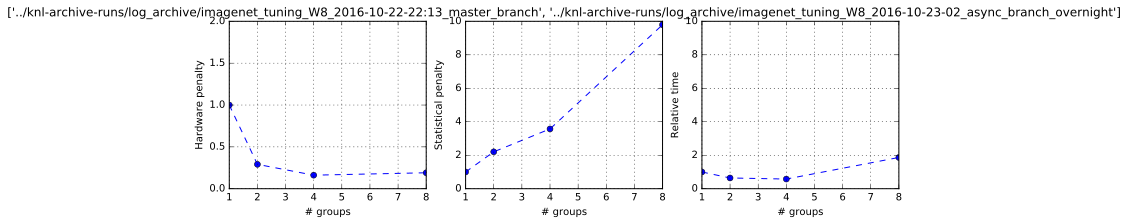

In [56]:
f,ax=plt.subplots(1,3,sharey=False, figsize=(12,3))
plot_he(ax[0])
plot_se(ax[1])
plot_relative_time(ax[2])
ax[1].set_title(experiment_directory);

In [207]:
all_seconds_per_batch

[5.585445833992095, 2.1680939055727553, 1.2040026623376625, 1.418444371124031]

In [61]:
int(np.ceil(50/float(60)))

1

In [82]:
import numpy as np

In [84]:
a = np.random.randn(3,2)

In [87]:
a.ravel()[0]

-0.23193500830132188

In [90]:
print("%.12f" % np.pi)

3.141592653590
